In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import logging

import scipy.stats
import numpy as np

import diffxpy.api as de

/Users/david.fischer/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Generate some data:

In [2]:
from batchglm.api.models.nb_glm import Simulator

sim = Simulator(num_observations=2000, num_features=100)
sim.generate_sample_description(num_batches=2, num_confounders=2)
# sample parameters from positive truncated N(1, 0.1)
mu=1; phi=0.1
sim.generate_params(rand_fn_loc=lambda size: mu + scipy.stats.truncnorm.rvs(-mu / phi, np.infty, scale=phi, size=size))
sim.generate_data()

# count data
X = sim.X
# sample description
sample_description = sim.sample_description

The sample description should be a pandas DataFrame with `num_observations` rows.
Each column should represent a property of the dataset.

The module `batchglm.api.data` contains some helper functions which can be useful to create this sample description:

- `sample_description_from_anndata()`
- `sample_description_from_xarray()`

In [3]:
sample_description.drop_duplicates()

,batch,condition
observations,,
0,0,0
1,0,1
1000,1,0
1001,1,1


# Run differential expression test:

Here, we run a t-test between the condition groups within each batches. Similarly, all other simple differential expression tests can be mapped onto a partition of the data set.

In [4]:
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("batchglm").setLevel(logging.INFO)
logging.getLogger("diffxpy").setLevel(logging.INFO)

import diffxpy.api as de

# Create partitions of data set.
part = de.test.partition(
    data=X, 
    partition = "batch",
    sample_description=sample_description)
# Run tests on each partition.
test = part.t_test(
    grouping="condition"
)

Similarly, one can also map a likelihood-ratio test across the partitions:

In [5]:
test_wald = part.wald(
    factor_loc_totest="condition", formula="~1+condition", noise_model="nb"
)

Estimating model...
Using closed-form MLE initialization for mean
Using closed-form MME initialization for dispersion


/Users/david.fischer/gitDevelopment/batchglm/batchglm/train/tf/nb_glm/estimator.py:746: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a_prime = np.linalg.lstsq(unique_design_loc, a)
/Users/david.fischer/gitDevelopment/batchglm/batchglm/train/tf/nb_glm/estimator.py:776: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b_prime = np.linalg.lstsq(unique_design_scale, b)


training strategy: [{'learning_rate': 0.01, 'convergence_criteria': 't_test', 'stop_at_loss_change': 0.25, 'loss_window_size': 10, 'use_batching': False, 'optim_algo': 'GD'}]
Beginning with training sequence #1
Training sequence #1 complete
Estimating model ready
Estimating model...
Using closed-form MLE initialization for mean
Using closed-form MME initialization for dispersion


/Users/david.fischer/gitDevelopment/batchglm/batchglm/train/tf/nb_glm/estimator.py:746: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  a_prime = np.linalg.lstsq(unique_design_loc, a)
/Users/david.fischer/gitDevelopment/batchglm/batchglm/train/tf/nb_glm/estimator.py:776: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b_prime = np.linalg.lstsq(unique_design_scale, b)


training strategy: [{'learning_rate': 0.01, 'convergence_criteria': 't_test', 'stop_at_loss_change': 0.25, 'loss_window_size': 10, 'use_batching': False, 'optim_algo': 'GD'}]
Beginning with training sequence #1
Training sequence #1 complete
Estimating model ready


# Obtaining the results

## Obtain results across all tests

In [6]:
test.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean
0,0,6.780058e-01,7.255701e-01,-0.003551,310.6645
1,1,1.957075e-05,5.436320e-05,-0.060096,8356.1215
2,2,3.423769e-07,1.316834e-06,0.110693,7134.1985
3,3,3.974598e-13,4.968248e-12,-0.222976,3303.3015
4,4,1.966670e-07,8.194457e-07,0.173295,1925.3105
5,5,5.734555e-03,1.146911e-02,0.095413,9170.9355
6,6,1.541421e-03,3.853552e-03,-0.079690,1449.1825
7,7,1.829474e-01,2.506129e-01,0.091009,8687.8170
8,8,1.310968e-04,4.369892e-04,-0.095170,7875.4185
9,9,5.624384e-06,1.814317e-05,0.123845,1147.4590


In [7]:
test_wald.summary().iloc[:10,:]

,gene,pval,qval,log2fc,mean
0,0,6.770591e-01,7.270938e-01,-0.003551,310.6645
1,1,2.021802e-05,5.616118e-05,-0.060096,8356.1215
2,2,2.938577e-07,1.175431e-06,0.110692,7134.1985
3,3,8.815171e-14,1.259310e-12,-0.222976,3303.3015
4,4,9.876257e-08,4.236880e-07,0.173295,1925.3105
5,5,5.488949e-03,1.097790e-02,0.095413,9170.9355
6,6,1.380078e-03,3.538661e-03,-0.079691,1449.1825
7,7,1.812106e-01,2.482337e-01,0.091009,8687.8170
8,8,1.092866e-04,3.642885e-04,-0.095170,7875.4185
9,9,4.364346e-06,1.407854e-05,0.123845,1147.4590


## Obtain results for one specific test

The individual partitions are:

In [8]:
test.partitions

['0', '1']

In the following, we will inspect the test within partition '0'.

The p-/q-values can be obtained by calling test.pval / test.qval:

In [9]:
test.tests[0].qval[:10]

array([7.25570079e-01, 1.09573885e-01, 1.07491718e-02, 4.96824804e-12,
       9.48693509e-03, 1.14691106e-02, 3.85355234e-03, 2.50612901e-01,
       4.36989222e-04, 1.44496415e-01])

test.summary() returns a pandas DataFrame with a quick overview of the test results:

In [10]:
test.tests[0].summary().iloc[:10,]

,gene,pval,qval,log2fc,mean,zero_mean,zero_variance
0,0,6.780058e-01,7.255701e-01,-0.014802,320.673,False,False
1,1,7.451024e-02,1.095739e-01,-0.060096,7939.305,False,False
2,2,5.267094e-03,1.074917e-02,0.086749,7396.120,False,False
3,3,3.974598e-13,4.968248e-12,-0.255442,3277.618,False,False
4,4,4.363990e-03,9.486935e-03,0.120831,1989.591,False,False
5,5,5.734555e-03,1.146911e-02,0.095413,9122.860,False,False
6,6,1.541421e-03,3.853552e-03,-0.098705,1586.739,False,False
7,7,1.829474e-01,2.506129e-01,0.091009,8566.043,False,False
8,8,1.310968e-04,4.369892e-04,-0.114376,7838.385,False,False
9,9,1.011475e-01,1.444964e-01,0.058356,1176.397,False,False


- `gene`: gene name / identifier
- `pval`: p-value of the gene
- `qval`: multiple testing - corrected p-value of the gene
- `log2fc`: log_2 fold change between `no coefficient` and `coefficient`

`test.plot_volcano()` creates a volcano plot of p-values vs. fold-change:

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c2394e0f0>)

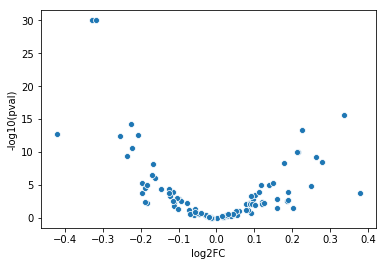

In [11]:
test.tests[0].plot_volcano()